In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import networkx as nx

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
# conda install conda-forge::biopython
from Bio.SVDSuperimposer import SVDSuperimposer
from tqdm import tqdm

# from numpy import dot
from filament import *
from voxelizer import *

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

%load_ext autoreload
%autoreload 2

/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/writhemap.py:16: UserWarning: Cython version of writhemap (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(
/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/eval_link.py:10: UserWarning: Cython version of linkingnumber (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(


In [2]:
# Load H-NS s1s1 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/0_s1s1/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
# start_open = md.load(loc_dimers+f'dry_open.xtc',top=loc_dimers+f'dry_open.pdb').remove_solvent()
# start_closed = md.load(loc_dimers+f'dry_closed.xtc',top=loc_dimers+f'dry_closed.pdb').remove_solvent()
# s1s1 = md.join([start_open,start_closed,md.join(short_trajs)])
s1s1 = md.join(short_trajs)

# Load H-NS s2s2 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/1_s2s2/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
s2s2 = md.join(short_trajs)

# Load H-NS dbd to DNA complex
loc_dbd  = '/Users/thor/surfdrive/Data/h-ns/NAR/md/0_highaff/FI/drytrajs/'
traj = [md.load(loc_dbd+f'dry_{i}.xtc',top=loc_dbd+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
dna_complex = md.join(traj)

In [4]:
# Define segments of the protein
n = 2 # Overlap of residues between segments

segments = {'s1':np.arange(0,41+n),
            'h3':np.arange(41-n,53+n),
            's2':np.arange(53-n,82+n),
            'l2':np.arange(82-n,95+n),
            'dbd':np.arange(95-n,137)}

# Site map contains a dictionary with the (sub)trajectories of different sites of the protein catergorized from the s1s1 and s2s2 dimers
mapper = SiteMapper(s1s1, s2s2, segments=segments, k=100)
site_map = mapper.get_site_map()
site_map['complex'] = dna_complex


#  Paramers to make filament
n_dimers = 6
chains_to_dna = [0,4,7,11]#list(range(0,n_dimers*2)) #[2,4,5,7,9] #[0,1] # #list(range(0,n_dimers*2)) #  [0,1,]#,3,5] #list
save = True

# Initialize class to assemble the filament
assembler = Assembler(site_map=site_map)

# Add dimers
print(f'Assembling {n_dimers} H-NS dimers:')
for idx in tqdm(range(n_dimers)):
    assembler.add_dimer(segment='fixed',verbose=True)  

# Add DNA oligo's
n_dna = len(chains_to_dna)
if n_dna > 0:
    print(f"Assembling {n_dna} DNA oligo's:")
    for chainid in tqdm(chains_to_dna):
        assembler.add_dna(chainid=chainid)

# Retrive the trajectory object
traj = assembler.get_traj()

# Store structure as pdb
if save:
    traj.save(f'./pdbs/0_dimer_{assembler.n_dimers}_{assembler.n_dna}.pdb')    


view = nv.show_mdtraj(traj)
view            

Assembling 6 H-NS dimers:


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Assembling 4 DNA oligo's:


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


NGLWidget()

In [5]:
path_goals = []
DNA_residue_names = ['DG','DC','DT','DA']
DNA_chainids = []
for chain in traj.top.chains:
    for res in chain._residues:
         if str(res.name) in DNA_residue_names:
            DNA_chainids.append(res.chain.index)
DNA_chainids = np.unique(DNA_chainids)
DNA_chainids = np.array([DNA_chainids[i:i + 2] for i in range(0, len(DNA_chainids), 2)])
DNA_chainids    

array([[12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [9]:

COM_primes = []
idx = 0
for chainids in DNA_chainids:
    nuc = mdna.load(traj, chainids=chainids)
    frames = nuc.get_frames()

    if idx == 0:
        COM_primes.append(frames[0][0][0]-np.array([3,-1,0]))
        COM_primes.append(frames[0][0][0])
    elif idx == 3:
        COM_primes.append(frames[-1][0][0]+np.array([0,-2,0]))
        COM_primes.append(frames[-1][0][0]+np.array([10,-3,0]))
    else:
        COM_primes.append(frames[6][0][0])

    idx+=1
        
COM_primes = np.array(COM_primes)
# remove the first and last points, because we don't want to connect them to the filament (maybe later extend)
# points = COM_primes[1:-1]
points = COM_primes
points

(12, 1, 4, 3)
(12, 1, 4, 3)
(12, 1, 4, 3)
(12, 1, 4, 3)
[array([-22.80361938,   7.98092842,  -5.2759099 ]), array([-19.80361938,   6.98092842,  -5.2759099 ]), array([-0.23091133, 12.14510632, -2.38277626]), array([20.08272934, 14.04665947, -2.81316781]), array([36.89089966, 14.49078751, -5.97305775]), array([46.89089966, 13.49078751, -5.97305775])]


array([[-22.80361938,   7.98092842,  -5.2759099 ],
       [-19.80361938,   6.98092842,  -5.2759099 ],
       [ -0.23091133,  12.14510632,  -2.38277626],
       [ 20.08272934,  14.04665947,  -2.81316781],
       [ 36.89089966,  14.49078751,  -5.97305775],
       [ 46.89089966,  13.49078751,  -5.97305775]])

Random sequence: ACCGCTGGCGCGACAGTTCTAGTGAAGCCCGGCGAAGGTGCGCCCAATGAGGTTCCATTAGGACGGAAGGTCATTGTCGTTCGGCCGAAGCGAAGTACTTGCAAGCTAATCAGTCGAAACCTGGATTGTGCGCATGCTGGAGAGGGCGTAGTCATTAGACAGCATTTGATACAGCCGGGTTCAGGGAATTAACCGGGAGTCTCGGTACTTGT 



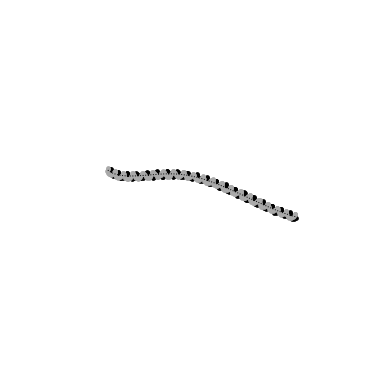

In [13]:
dna = mdna.make(control_points=points)
dna.draw()

In [16]:

traj.save('pdbs/lateral_filament_unoptimized_piecesDNA.pdb')
dna_traj = dna.get_traj()
protein = traj.atom_slice(traj.top.select('protein'))
protein.save('pdbs/lateral_filament_unoptimized_noDNA.pdb')
new_traj = dna_traj.stack(protein)   
new_traj.save('pdbs/lateral_filament_unoptimized.pdb')
view = nv.show_mdtraj(new_traj)
view

NGLWidget()